## Statistical procedure for the data of the higgs boson

The following procedure is gathered from the CMS - NOTE 2011-005, and is the statistical approach used to do an hypothesis test to determine wether the results for the Higgs boson mass produced by the data is only created by background or an actual signal in combination with background.

We make the signal and the background functions of the nuiance parameter $\theta$, and denote them $s\left(\theta\right)$ and $b\left(\theta\right)$ respectfully.

1. Construct the likelyhood function
$$\mathcal{L}\left(\mbox{data}|\mu,\theta\right) = \mbox{Poisson}\left(\mbox{data}|\mu \cdot s\left(\theta\right) + b\left(\theta\right)\right)\cdot p\left(\tilde{\theta}|\theta\right)$$

* Data represents either actual experimental observation or pseudo-data used to construct sampling distributions

* $\mu$ is the signal strength modifier and $\theta$ represents the full suite of nuiance parameters

* Poissons(data|$\mu s + b$) stands for a product of Poisson probabilities to observe $n_i$ events in bins $i$:
$$\prod_{i} \frac{\left(\mu s_i + b_i\right)^{n_i}}{n_i !} e^{-\mu s_i - b_i}$$

2. To compare the compability of the data with the background -only and signal + background hypothesis, the test statistic $$\tilde{q_{\mu}} =  - 2ln \frac{\mathcal{L}\left(\mbox{data}|\mu,\hat{\theta_{\mu}}\right)}{\mathcal{L}\left(\mbox{data}|\hat{\mu},\hat{\theta_{\mu}}\right)},$$ with $0 \leq \hat{\mu} \leq \mu$. Where $\hat{\theta_{\mu}}$ refers to the conditional maximum likelyhood estimate of $\theta$, given the signal strength paramter $\mu$ and data. $\hat{\mu}$ and $\hat{\theta}$ correspond to the global maximum of the likelihood.

3. Find the observed value of the test statisitc $\tilde{q_{\mu}^{obs}}$ for the given signal strength modifier $\mu$ under test.

4. Find values of the nuisance paramters $\hat{\theta_{o}^{obs}}$ and $\hat{\theta}_{\mu}^{\mbox{obs}}$ best describing the experimentally observed data, for the background only and signal + background hypothesis, respectively. 

5. Use (a bit unsure because, in the CMS document it says generate toy monte carlo pseudo-data, but I assume that part is done, so I assume we are just supposed to use the generated one) the generated pseudo-data to construct $pdf$s $f\left(\tilde{q_{\mu}}|\mu, \hat{\theta}_{\mu}^{obs}\right)$ and $f\left(\tilde{q_{\mu}}|0, \hat{\theta}_{0}^{obs}\right)$ assuming a signal with strength $\mu$ in the signal + background hypothesis and for the background only hypothesis ($\mu = 0$).

6. Having constructed $f\left(\tilde{q_{\mu}}|\mu, \hat{\theta}_{\mu}^{obs}\right)$ and $f\left(\tilde{q_{\mu}}|0, \hat{\theta}_{0}^{obs}\right)$ distributions, define two p-values to be associated with the actual observation for the signal + background and background-only hypothesis, $p_{\mu}$ and $p_b$:
$$p_{\mu} = P\left(\tilde{q_{\mu}} \geq \tilde{q}_{\mu}^{obs}|\mbox{signal + background}\right) = \int_{\tilde{q}_{\mu}^{obs}}^{infty} f\left(\tilde{q}_{\mu}|\mu, \hat{\theta}_{\mu}^{obs}\right) d\tilde{q_{\mu}} $$

$$1- p_{b} = P\left(\tilde{q_{\mu}} \geq \tilde{q}_{\mu}^{obs}|\mbox{background only}\right) = \int_{\tilde{q}_{+0}^{obs}}^{infty} f\left(\tilde{q}_{\mu}|0, \hat{\theta}_{0}^{obs}\right) d\tilde{q_{\mu}}$$

and calculate $CL_{s}\left(\mu\right) = \frac{p_{\mu}}{1-p_{b}}$.

7. If, for $\mu = 1$, $CL_s \leq \alpha$, we would state that the SM Higgs boson is excluded with (1 - $\alpha$) confidence level.

8. To quote the 95$\%$ Confidence Level upper limit on $\mu$, to be further denoted as $\mu^{95\%CL}$ we adjust $\mu$ until we reach $CL_s = 0.05$.


Further the procedure states that the test statistic used for the higgs boson is $q_{\mu}$ with $\hat{\mu} \geq 0$. (see expression for $q_{\mu}$ above.)

In [401]:
# Useful packages
import pandas as pd
import scipy.stats as ss
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy as sp
import pyhf
from matplotlib.pyplot import figure
from tqdm import tqdm
import scipy.integrate as integrate
import scipy.special as special

In [75]:
# In this document we have neglected the error-parameter theta
# Veslemøy and Ema

### Uploading data

In [445]:
# Uploading counts from data
# considering only m>100 GeV
sim_signal_counts = np.load(r'signal_counts.npy')[9:,]
sim_background_counts = np.load(r'background_counts.npy')[9:,]
true_counts = np.load(r'true_counts.npy')[9:,]
#bins_data = np.load(r'C:\Users\vesle\Desktop\data\bins.npy')
# \Users\vesle\Desktop\Even_longer\

In [446]:
# checking that they all have the same length
print('Number of bins:')
print(len(sim_signal_counts))
print(len(sim_background_counts))
print(len(true_counts))

Number of bins:
70
70
70


### Defining necessary functions

In [441]:
# We can assume the data we are getting in is an array of discrete counts;
# The likelihood function for each bin is given by the poisson distribution
# pmf(k, mu, loc=0)

# log of likelihood function to avoid underflow

def log_likelihood(mu,s,b,n):
    """ 
    s = number of expected signal events in bin i 
    b = number of expected background events in bin i 
    n = number of real events in bin i """
    nu = mu*s +b
    return sum(np.log(ss.poisson.pmf(n,nu)))

# we construct the test statistic q ̃_mu based on the profile likelihood ratio:
def q_tilde_mu(mu_1, mu_2, s, b, t, func=log_likelihood):
    log_val = func(mu_1,s,b,t) - func(mu_2,s,b,t)
    return -2*log_val 


### Finding the q-values of our original data

The best fit value of mu for our original data is:  0.8779387768451958


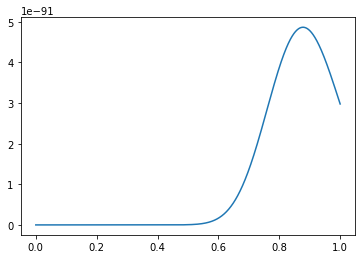

In [447]:
# Finding mu that maximize the likelihood function in [0,1]
# Want to optimize mu with regards to the likelihood function
# Can use scipy.optimize.minimize to find the minimum

fun = lambda mu: -log_likelihood(mu,sim_signal_counts,sim_background_counts,true_counts)
mu_opt = sp.optimize.minimize(fun,0.5,bounds=((0,1),))
mu_max = mu_opt["x"][0]
print("The best fit value of mu for our original data is: ",mu_max)

mu = np.linspace(0, 1, 3001)
likelihood_val = []
for i in mu:
    x = log_likelihood(i, sim_signal_counts, 
                          sim_background_counts, 
                          true_counts)
    likelihood_val.append(np.exp(x))

plt.plot(mu, likelihood_val)

#mu_max = mu[likelihood_val.index(max(likelihood_val))]
#print('Maximum likelihood estimator for mu:', mu_max)


In [448]:
# Finding q0_obs as ratio of Likelihood-functions with mu = 0 and mu = best fit 
q_obs_0 = q_tilde_mu(0,mu_max,sim_signal_counts,sim_background_counts,true_counts)
print("q_obs_0: ",q_obs_0)

q_obs_0:  165.51066582228117


In [449]:
# Ratio of Likelyhood-functions with mu = 1 and mu = best fit 
q_obs_1 = q_tilde_mu(1,mu_max,sim_signal_counts,sim_background_counts,true_counts)
print("q_obs_1: ",q_obs_1)

q_obs_1:  0.9825022062841526


In [ ]:
# q_obs_0 big    --> the likelihood computed on the background-only hypothesis
#                    smaller than the maximum (maybe too much distant?)
# q_obs_1 small  --> near the maximum of the likelihood (maybe too small??)
#

### Costructing the pdf of $ \tilde{q}_{\mu} $ generating toy Monte Carlo pseudo-data

In [322]:
# Generate toy Monte Carlo pseudo-data to construct pdfs f(q^~_μ |μ) and f (q^ ̃_μ |0 )
# assuming a signal with strength μ in the signal+background hypothesis and for the
# background-only hypothesis (μ = 0). 

def create_toy(mu,s,b):
    """
    return a random Poisson distributed value
    with mu*s + b as its expected value
    """
    return ss.poisson.rvs((mu*s+b),size=1)


def create_toy_distr(mu,s,b,func = create_toy):
    """
    generate for each bin a random Poisson 
    distributed values in according to the 
    counts for simulated signal and background 
    """
    toys_list = np.zeros(len(s))
    for i in range(len(s)):
        toys_list[i] = func(mu,s[i],b[i])
        
    return toys_list

In [370]:
# creating a dataframe with toy distributions mimiking our true counts

# For mu = 0
toy_data_mu_0 = pd.DataFrame([])

for i in tqdm(range(10000)):
    toys           = pd.DataFrame(create_toy_distr(0,sim_signal_counts, sim_background_counts)).T
    toy_data_mu_0  = pd.concat([toy_data_mu_0,toys],ignore_index=True,axis = 0)
    

100%|██████████████████████████████████████████████████| 10000/10000 [01:18<00:00, 126.79it/s]


In [ ]:
#toy_data_mu_1

In [371]:
#for mu = 1
toy_data_mu_1 = pd.DataFrame([])

for i in tqdm(range(10000)):
    toys = pd.DataFrame(create_toy_distr(1,sim_signal_counts, sim_background_counts)).T
    toy_data_mu_1 = pd.concat([toy_data_mu_1,toys],ignore_index=True,axis = 0)

100%|██████████████████████████████████████████████████| 10000/10000 [01:19<00:00, 126.54it/s]


In [346]:
#toy_data_mu_1

,0,1,2,3,4,5,6,7,8,9,...,60,61,62,63,64,65,66,67,68,69
0,48.0,23.0,5.0,7.0,3.0,3.0,1.0,5.0,6.0,6.0,...,15.0,17.0,17.0,9.0,10.0,10.0,17.0,13.0,22.0,11.0
1,46.0,25.0,8.0,5.0,9.0,9.0,3.0,7.0,4.0,7.0,...,14.0,13.0,15.0,12.0,13.0,17.0,12.0,19.0,7.0,9.0
2,40.0,30.0,8.0,2.0,9.0,2.0,10.0,9.0,9.0,7.0,...,17.0,22.0,19.0,21.0,18.0,14.0,14.0,12.0,11.0,11.0
3,49.0,33.0,6.0,4.0,11.0,7.0,7.0,8.0,6.0,3.0,...,7.0,21.0,12.0,16.0,22.0,13.0,11.0,16.0,11.0,11.0
4,51.0,32.0,10.0,6.0,6.0,8.0,5.0,6.0,2.0,9.0,...,26.0,23.0,14.0,20.0,9.0,10.0,10.0,14.0,15.0,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,39.0,44.0,5.0,7.0,8.0,6.0,9.0,7.0,3.0,3.0,...,10.0,15.0,18.0,18.0,16.0,13.0,12.0,14.0,15.0,15.0
2996,43.0,35.0,10.0,5.0,5.0,4.0,10.0,10.0,7.0,7.0,...,22.0,7.0,15.0,17.0,12.0,13.0,12.0,7.0,13.0,14.0
2997,43.0,26.0,13.0,3.0,8.0,5.0,4.0,7.0,8.0,7.0,...,18.0,12.0,12.0,16.0,13.0,22.0,8.0,19.0,7.0,17.0
2998,38.0,32.0,12.0,5.0,8.0,8.0,5.0,9.0,9.0,9.0,...,27.0,11.0,9.0,20.0,11.0,10.0,8.0,18.0,16.0,16.0


#### Collect all the optimal $\mu$ for each generated toy data set

In [372]:
# Need to make a loop where we loop over all the different toy-datasets
# and calculate the optimal mu for each of them

n_toys = len(toy_data_mu_0.iloc[:,0])

# With mu equal to 0
mu_s_0 = np.zeros(n_toys)

# With mu equal to 1
mu_s_1 = np.zeros(n_toys)

for i in tqdm(range(n_toys)):
    index     = i
    fun0      = lambda mu: -log_likelihood(mu,
                                           sim_signal_counts,
                                           sim_background_counts,
                                           toy_data_mu_0.iloc[index,:])
    
    fun1      = lambda mu: -log_likelihood(mu,
                                           sim_signal_counts,
                                           sim_background_counts,
                                           toy_data_mu_1.iloc[index,:])
    
    mu_opt_i_0  = sp.optimize.minimize(fun0,0.5,bounds=((0,1),))["x"]
    mu_opt_i_1  = sp.optimize.minimize(fun1,0.5,bounds=((0,1),))["x"]
    mu_s_0[i]   = mu_opt_i_0
    mu_s_1[i]   = mu_opt_i_1

100%|██████████████████████████████████████████████████| 10000/10000 [01:31<00:00, 109.64it/s]


In [503]:
#Creating q's with mu=1 and | mu=0

num    = len(toy_data_mu_0.iloc[:,0])
q_0_1s = np.zeros(num)

for i in range(num):
    q_0_1s[i] = q_tilde_mu(1, mu_s_0[i],
                       sim_signal_counts,
                       sim_background_counts,
                       toy_data_mu_0.iloc[i,:])

In [504]:
# Creating q's with mu=1 and | mu=1

num    = len(toy_data_mu_1.iloc[:,0])
q_1_1s = np.zeros(num)

for i in range(num):
    q_1_1s[i] = q_tilde_mu(1, mu_s_1[i],
                       sim_signal_counts,
                       sim_background_counts,
                       toy_data_mu_1.iloc[i,:])

### Histogram representation of toy disitrbutions for q

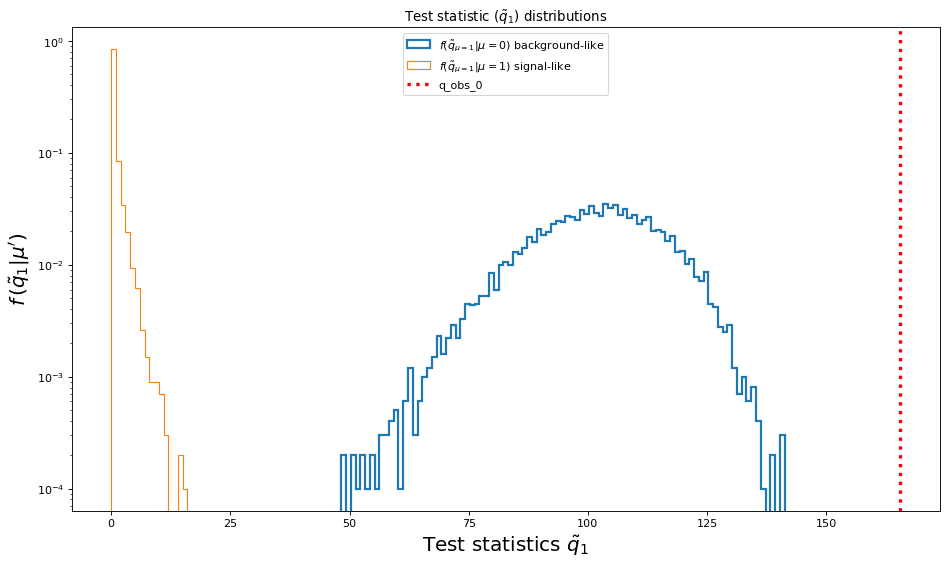

In [505]:
figure(figsize=(14, 8), dpi=80)
histogram_0 = plt.hist(q_0_1s, 
                       bins = np.arange(min(q_0_1s),max(q_0_1s) + 0.5,1),
                       histtype = 'step',
                       facecolor='c', 
                       density=True,
                       label=r"$f(\tilde{q}_{\mu = 1}|\mu = 0)$ background-like",
                       linewidth=2)


histogram_1 = plt.hist(q_1_1s, 
                       bins = np.arange(min(q_1_1s),max(q_1_1s) + 0.5,1),
                       histtype = 'step',facecolor='c',
                       label =r"$f(\tilde{q}_{\mu = 1}|\mu = 1)$ signal-like",
                       density = 'true')
                       
plt.axvline(q_obs_0, color='red', linestyle='dotted', linewidth=3, label = "q_obs_0")
plt.yscale('log')

plt.xlabel(r"Test statistics $\tilde{q}_1$", fontsize=18)
plt.ylabel(r"$f\,(\tilde{q}_1|\mu')$", fontsize=18)
plt.title(r"Test statistic $(\tilde{q}_1)$ distributions")
plt.legend()


plt.setp(axes, xlim=(0, 150), ylim=(1e-3, 10), yscale="log")
fig.set_size_inches(14, 6)
fig.tight_layout(pad=2.0)



### p-values

We define two p-values to be associated with the actual observation for the signal+background and background-only hypotheses, $p_{\mu}$ and $p_b$:

In [434]:
# retrieve counts and bins 
counts0, bins0, bars0 = histogram_0
counts1, bins1, bars1 = histogram_1
bin_width = bins0[1] - bins0[0]

counts1_q = counts1[bins1[:-1]>q_obs_1]
p_val_mu = sum( bin_width*counts1_q)
p_val_mu

counts0_q = counts0[bins0[:-1]>q_obs_0]
p_val_b = sum( bin_width*counts0_q)

CL = p_val_mu/(1 - p_val_b)
CL

0.4809999999999998

The presence of the signal is quantified by the background-only p-value, i.e. the probability for the background to fluctuate and give an excess of events as large or larger than the observed one. As before, this requires defining a test statistic and the construction of its sampling distribution. For a given Higgs boson mass hypothesis mH, the test statistic used is q0


In [455]:
mu_s_0 = np.zeros(100000)
q_0_1s = np.zeros(100000)


for i in tqdm(range(100000)):
    toy_count0 = create_toy_distr(0,sim_signal_counts, sim_background_counts)
    
    fun0      = lambda mu: -log_likelihood(mu,
                                           sim_signal_counts,
                                           sim_background_counts,
                                           toy_count0)

    
    mu_opt_i_0  = sp.optimize.minimize(fun0,0.5,bounds=((0,1),))["x"]
    mu_s_0[i]   = mu_opt_i_0
    q_0_1s[i]   = q_tilde_mu(0, mu_s_0[i],
                       sim_signal_counts,
                       sim_background_counts,
                       toy_count0)


100%|█████████████████████████████████████████████████| 100000/100000 [18:57<00:00, 87.88it/s]


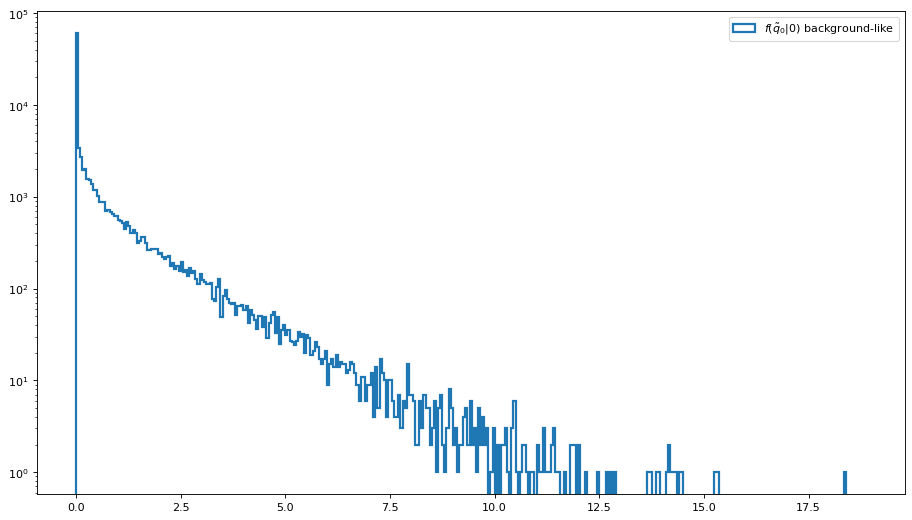

In [461]:
figure(figsize=(14, 8), dpi=80)
histogram_0 = plt.hist(q_0_1s, 
                       bins = np.arange(min(q_0_1s),max(q_0_1s) + 0.5,0.05),
                       histtype = 'step',
                       facecolor='c', 
                       #density=True,
                       label=r"$f(\tilde{q}_0|0)$ background-like",
                       linewidth=2)

#plt.axvline(q_obs_0, color='black', linestyle='dotted', linewidth=3, label = "q_obs_0")
plt.yscale('log')

plt.legend()

In [464]:
p_estimate = 0.5*(1 - special.erf(q_obs_0/2))
p_estimate

0.0

In [ ]:
# We have put in the line for q_obs_1, which is the q-funciton evaluated with mu_1 = 1 and mu_2 = best fit 
# We get that this is very low, much lower than in the cms-document. The value for q with the ratio of no signal vs. best fit
# is very high however, so we are not sure if that is correct. Also, our toy distributions for mu = 1 and mu = 0 do
# not overlap at all. Usually this would be the ideal case, but we were thinking we may have done something wrong as
# as we assumed they would be a bit more overlapping as in the CMS-case.

In [482]:
# trying with pyhf

model = pyhf.simplemodels.uncorrelated_background(
    [x for x in sim_signal_counts], [x for x in sim_background_counts], [x*0 for x in sim_background_counts]
)

data = pyhf.tensorlib.astensor( [x for x in true_counts] + model.config.auxdata)

print(f"Channels: {model.config.channels}")
print(f"Samples: {model.config.samples}")
print(f"Parameters: {model.config.parameters}")

test_mu   = 0.0
init_pars = model.config.suggested_init()

par_bounds   = model.config.suggested_bounds()
fixed_params = model.config.suggested_fixed()
par_bounds[model.config.poi_index] = (0, 1)
q0_obs = pyhf.infer.test_statistics.q0(test_mu, data, model, init_pars, par_bounds, fixed_params)
print("q_obs_0: ", q0_obs)

Channels: ['singlechannel']
Samples: ['background', 'signal']
Parameters: ['mu', 'uncorr_bkguncrt']
q_obs_0:  165.5106655953611


In [472]:
# mu' = 0: background-like
pars_bkg = model.config.suggested_init()
pars_bkg[model.config.poi_index] = 0.0
print(f"Background parameters: {list(zip(model.config.parameters, pars_bkg))}")

# mu' = 1: signal-like
pars_sig = model.config.suggested_init()
pars_sig[model.config.poi_index] = 1.0
print(f"Signal parameters: {list(zip(model.config.parameters, pars_sig))}")

# make the pdfs
pdf_bkg = model.make_pdf(pyhf.tensorlib.astensor(pars_bkg))
pdf_sig = model.make_pdf(pyhf.tensorlib.astensor(pars_sig))

Background parameters: [('mu', 0.0)]
Signal parameters: [('mu', 1.0)]


In [499]:
# note: pdf.sample takes in a "shape" N=(10000,) given the number of samples
n_samples = 10000

# mu' = 0
mc_bkg = pdf_bkg.sample((n_samples,))
# mu' = 1
mc_sig = pdf_sig.sample((n_samples,))

print(mc_bkg.shape)
print(mc_sig.shape)


(10000, 70)
(10000, 70)


In [500]:
init_pars    = model.config.suggested_init()
par_bounds   = model.config.suggested_bounds()
fixed_params = model.config.suggested_fixed()


qtilde_bkg = pyhf.tensorlib.astensor(
    [
        pyhf.infer.test_statistics.qmu_tilde(
            1.0, mc, model, init_pars, par_bounds, fixed_params
        )
        for mc in mc_bkg
    ]
)

qtilde_sig = pyhf.tensorlib.astensor(
    [
        pyhf.infer.test_statistics.qmu_tilde(
            1.0, mc, model, init_pars, par_bounds, fixed_params
        )
        for mc in mc_sig
    ]
)

In [501]:
toy_calculator_qtilde = pyhf.infer.utils.create_calculator(
    "toybased",
    model.expected_data(pars_sig),
    model,
    ntoys=n_samples,
    test_stat="qtilde",
)
qtilde_sig, qtilde_bkg = toy_calculator_qtilde.distributions(1.0)


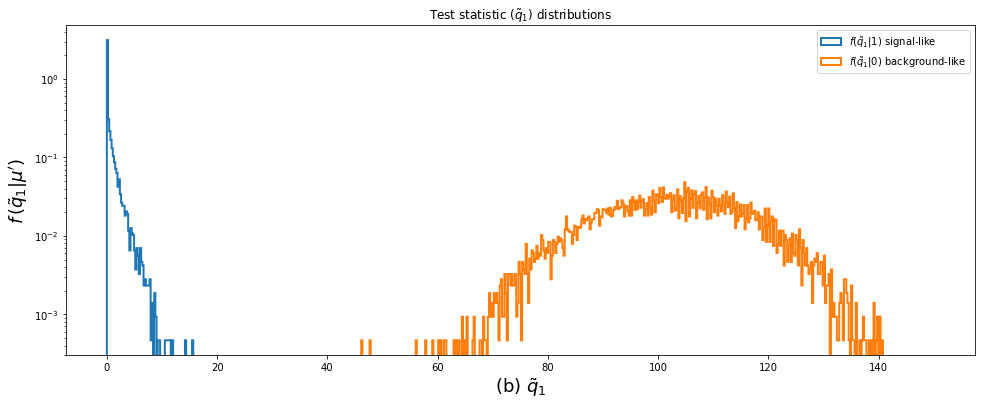

In [502]:
fig, ax = plt.subplots(nrows=1, ncols=1)
#for ax in axes:
#ax.set_xticks(np.arange(0, 500))
#ax1 = ax.flatten()

bins = np.linspace(0, 150, 700)

ax.hist(
    qtilde_sig.samples,
    bins=bins,
    histtype="step",
    density=True,
    label=r"$f(\tilde{q}_1|1)$ signal-like",
    linewidth=2,
)
ax.hist(
    qtilde_bkg.samples,
    bins=bins,
    histtype="step",
    density=True,
    label=r"$f(\tilde{q}_1|0)$ background-like",
    linewidth=2,
)
ax.set_xlabel(r"(b) $\tilde{q}_1$", fontsize=18)
ax.set_ylabel(r"$f\,(\tilde{q}_1|\mu')$", fontsize=18)
ax.set_title(r"Test statistic $(\tilde{q}_1)$ distributions")
ax.legend()
plt.yscale('log')

plt.setp(axes, xlim=(0, 50), ylim=(1e-3, 10), yscale="log")
fig.set_size_inches(14, 6)
fig.tight_layout(pad=2.0)